<a href="https://colab.research.google.com/github/DavideBruni/CIDL_lab/blob/main/CIDL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset creation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import LineString
%matplotlib inline

ENTRIES = 10_000
SEQ_LEN = 10
START = (-1, 1)
STEP_SIZE = (0, 0.5)
PHI_SIZE = ((-np.pi*2/3), (np.pi*2/3))

In [2]:
def check_intersection(lines):
    for i in range(len(lines) - 1):
        line1 = LineString([lines[i], lines[i + 1]])
        for j in range(i + 2, len(lines) - 1):
            line2 = LineString([lines[j], lines[j + 1]])
            if line1.intersects(line2):
                return True
    return False

def get_seq():
    points = []

    point = np.random.uniform(START[0], START[1], 2)
    points.append(point)
    for i in range(SEQ_LEN):
        step = np.random.uniform(STEP_SIZE[0], STEP_SIZE[1], 2)
        phi = np.random.uniform(PHI_SIZE[0], PHI_SIZE[1])
        point = point + step * np.array([np.cos(phi), np.sin(phi)])
        points.append(point)

    return np.array(points), check_intersection(points)

False


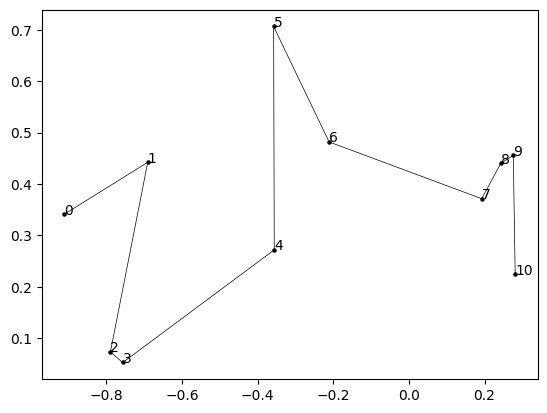

In [3]:
seq, intersect = get_seq()
print(intersect)
for i, (x, y) in enumerate(seq):
    plt.scatter(x, y, color='black', s=5)
    plt.text(x, y, i)
plt.plot(seq[:, 0], seq[:, 1], color='black', linewidth=0.5)
plt.show()

True


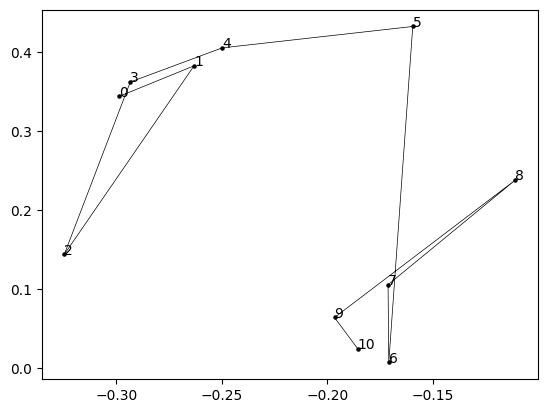

In [4]:
seq, intersect = get_seq()
print(intersect)
for i, (x, y) in enumerate(seq):
    plt.scatter(x, y, color='black', s=5)
    plt.text(x, y, i)
plt.plot(seq[:, 0], seq[:, 1], color='black', linewidth=0.5)
plt.show()

In [5]:
dataset = []

i = 0
while i < ENTRIES//2:
    print("Building dataset (intersect): ", i, "/", ENTRIES//2, end="\r")
    seq, intersect = get_seq()
    if intersect:
        dataset.append((seq, intersect))
        i += 1
print()

i = 0
while i < ENTRIES//2:
    print("Building dataset (not intersect): ", i, "/", ENTRIES//2, end="\r")
    seq, intersect = get_seq()
    if not intersect:
        dataset.append((seq, intersect))
        i += 1

# RNN creation


In [6]:
import torch

class RNNModel(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.rnn = torch.nn.Sequential(
        torch.nn.Linear(input_size + hidden_size, hidden_size),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size)
    )

    self.ff = torch.nn.Linear(hidden_size, output_size)

  def forward(self, x):
    hidden_state = torch.zeros(x.shape[0], self.hidden_size, device = x.device)
    for t in range(x.shape[1]):   # x.shape[1] sono le colonne, quindi il tempo
      input = torch.cat([x[:, t,:], hidden_state], dim=1)
      hidden_state = self.rnn(input)
    return self.ff(hidden_state)

In [7]:
from tqdm import tqdm

input_size = 2
hidden_size = 30
output_size = 2
model = RNNModel(input_size, hidden_size, output_size)
dl = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

EPOCH = 10

for epoch in range(EPOCH):
  bar = tqdm(dl)
  for points, classes in bar:
    points = points.float()
    classes = classes.type(torch.LongTensor)
    pred = model(points.float())
    loss = loss_fn(pred,classes)

    accuracy = (pred.argmax(dim=1) == classes).float().mean()
    bar.set_description(f"Loss {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Loss 0.6599, Accuracy: 0.5000: 100%|██████████| 313/313 [00:02<00:00, 125.14it/s]


#LSTM

In [8]:
class LSTMModel(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=3, batch_first=True)
    self.ff = torch.nn.Linear(hidden_size, output_size)


  def forward(self, x):
    hidden_state = torch.zeros(x.shape[0], self.hidden_size, device = x.device)
    for t in range(x.shape[1]):   # x.shape[1] sono le colonne, quindi il tempo
      input = torch.cat([x[:, t,:], hidden_state], dim=1)
      hidden_state, _ = self.lstm(input)
    return self.ff(hidden_state)

In [ ]:
model_lstm = LSTMModel(input_size, hidden_size, output_size)
dl = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr = 0.0001)

EPOCH = 3

for epoch in range(EPOCH):
  bar = tqdm(dl)
  for points, classes in bar:
    points = points.float()
    classes = classes.type(torch.LongTensor)
    print(type(points))
    pred = model_lstm(points.float())
    loss = loss_fn(pred,classes)

    accuracy = (pred.argmax(dim=1) == classes).float().mean()
    bar.set_description(f"Loss {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Loss nan, Accuracy: 0.4062:   0%|          | 0/313 [00:00<?, ?it/s]